In [93]:
from datetime import datetime, timedelta
from IPython.display import clear_output
import pandas_datareader.data as web
from IPython.display import display
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import time

pd.options.display.float_format = '{:,.2f}'.format

# Downloads tickers and formatting data

### Fetching tickers from nasdaq and filtering out ETFs are stocks that we have a problem getting their prices

In [2]:
def get_all_tickers(etf=False):
    # Get a list of all available tickers from Yahoo Finance
    all_tickers = web.get_nasdaq_symbols()
    all_tickers = all_tickers[~all_tickers["Test Issue"]]  # Filter out stocks that we can't fetch their data for some reason
    
    if not etf:
        all_tickers = all_tickers[~all_tickers["ETF"]]  # Filter out ETFs
    tickers = all_tickers.index.tolist()
    return [str(ticker) for ticker in tickers if str(ticker).isalpha()]

### Downloads data

In [135]:
def get_data(tickers_list):
    return yf.download(tickers_list, period="5Y")

In [136]:
s = time.time()
# data = get_data(get_all_tickers())
data = get_data("SILC")
data_cop = data.copy()
print(time.time() - s)

[*********************100%***********************]  1 of 1 completed
0.5013821125030518


### Strategy and more shit

### Parsing initial dataframe

In [4]:
def parse_data(data):
    df = data.copy()
    df.drop(columns=["Low", "Adj Close"], inplace=True)
    window_size = 252
    df["High52"] = df["High"].rolling("365D").max()
    df["doh"] = np.datetime64("1900-01-01")
    df["Strategy"] = 0
    df["pos"] = np.nan  # Piece of shit, or position
    
    # df["doh"] = df.index.where(df["High52"] != df["High52"].shift())
    # Iterate through the DataFrame to find the dates of break (dob)
    for i in range(window_size, len(df)):
        if df['High52'][i] != df['High52'][i-1]:
            df.loc[df.index[i], 'doh'] = df.index[i]
        else:
            df.loc[df.index[i], 'doh'] = df["doh"][i-1]
    return df

In [5]:
def strategy(parsed_data, t_tresh1=75, t_thresh2=200, trail_stop=5):
    df = parsed_data.copy()

    time_thresh1 = timedelta(days=t_tresh1)  # Hit the high between 120 and 200 days ago (3 - 7 months)
    time_thresh2 = timedelta(days=t_thresh2)  
    
    # Buy signal
    buy_cond = df["High"].shift(-1) > df["High52"]
    buy_cond2 = (df.index - df["doh"] < time_thresh2)  & (df.index - df["doh"] > time_thresh1)
    
    df.loc[(buy_cond & buy_cond2), "Strategy"] = 1 
    
    #Devide to a lot of dataframes
    df["trades"] = (df["Strategy"] == 1).cumsum()
    trades_df = {grp: df_grp for grp, df_grp in df.groupby("trades")}
    conc_tmp_df = pd.DataFrame()
    
    for key, tmp_df in trades_df.items():
        tmp_df["trade_high"] = tmp_df["High"].cummax()
        sell_cond = (((tmp_df["trade_high"] - tmp_df["Close"]) / tmp_df["trade_high"]) * 100) > trail_stop
        tmp_df.loc[sell_cond, "Strategy"] = -1
        conc_tmp_df = pd.concat([conc_tmp_df, tmp_df])
    # df = pd.concat(dfs.values())
    df = conc_tmp_df.copy()
    # df.drop('trades', axis=1, inplace=True)
    # Sell cond- sell after 3 days, just for testing because I don't know yet how I should do it
    # sell_cond = ((df["Close"] - df["Close"].shift(2)) / df["Close"].shift(2)) * 100  # Sell if the percent 2 days ago gone down 3%
    # sell_cond = df["Strategy"].shift(3) == 1
    # df.loc[sell_cond, "Strategy"] = -1
    
    # Position
    df.loc[df['Strategy'].shift() == 1, 'pos'] = 1
    df.loc[df['Strategy'].shift() == -1, 'pos'] = 0
    # df["Stocks bought"] = df["pos"] * s_money//df["Open"]
    # df['Stocks bought'] = df['Stocks bought'].replace(to_replace=np.nan, method='ffill')
    df['pos'] = df['pos'].replace(to_replace=np.nan, method='ffill')
      
    return df

In [6]:
def sim(df1):
    df = df1.copy()
    df["Day profit"] = df["pos"] * (np.log(df["Close"]/(df["Close"].shift())))
    df["Hold"] = np.log(df["Close"]/(df["Close"].shift()))
    df["sReturn"] = df["Day profit"].cumsum().apply(np.exp)
    df["hReturn"] = df["Hold"].cumsum().apply(np.exp)
    
    # df['prev buy'] = df.index.where(df['Strategy'] == 1)
    # df['prev buy'] = df['prev buy'].shift(1).ffill()
    # df['prev buy'] = df['prev buy'].fillna(-1)
    # valid_idx = df["prev buy"].isin(df.index)

    # df["bought price"] = df["prev buy"].loc[valid_idx].map(df["Close"]) * df["pos"]

    # df.loc[df["pos"] == 0, "prev buy"] = np.NaN
    # df.loc[df["bought price"] == 0, "bought price"] = np.NaN
    
    # tmp = df.copy()
    # df['test'] = [i - df.index.get_loc(date) if date in df.index else np.NaN for i, date in enumerate(df["prev buy"])]
    # df["trail"] = np.NaN
    
    return df

In [27]:
def optimizer(ticker, time_thresh1, time_thresh2, trail_stop):

    data = get_data(ticker)
    parsed = parse_data(data)
    i = 0
    results = pd.DataFrame(columns=["time thresh1", "time thresh2", "trail stop", "strategy return", "Trades", "Hold return"])
    for tt1 in time_thresh1:
        for tt2 in time_thresh2:
            for trs in trail_stop:       
                strat_df = strategy(parsed, tt1, tt2, trs)
                res = sim(strat_df)
                retrn = res["sReturn"][-1]
                hold_r = res["hReturn"][-1]
                trades = res["trades"][-1]
                # new_row = pd.DataFrame({"time thresh1": [tt1], "time thresh2": [tt2], "trail stop": [trs], "strategy return": [retrn], "Trades": [trades], "Hold return": [hold_r], "dataframe": [res]})
                new_row = pd.DataFrame({"time thresh1": [tt1], "time thresh2": [tt2], "trail stop": [trs], "strategy return": [retrn], "Trades": [trades], "Hold return": [hold_r]})
                results = pd.concat([results, new_row], ignore_index=True)
    return results


time_thresh1 = range(50, 80, 2)
time_thresh2 = range(100, 250, 5)
trail_stop = range(1, 10, 1)
# time_thresh1 = range(70, 80, 5)
# time_thresh2 = range(100, 200, 60)
# trail_stop = range(1, 10, 2)
tickers = ["ABEO", "ABIO", "ABVC", "ACHV", "ACER", "ACST", "AAIC", "ABNB", "TSLA", "AAPL"]
# tickers = ["TSLA", "AAPL", "NVDA"]

s = time.time()
mult_opt = pd.DataFrame()
for ticker in tickers:
    opt = optimizer(ticker, time_thresh1, time_thresh2, trail_stop)
    # opt = opt.add_prefix(f"{ticker}_")
    opt.columns = pd.MultiIndex.from_product([[ticker], opt.columns])
    mult_opt = pd.concat([mult_opt, opt], axis=1, ignore_index=False)

print(time.time() - s)
mult_opt

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
785.8423097133636


ABEO                                                             \
     time thresh1 time thresh2 trail stop strategy return Trades Hold return   
0              50          100          1            1.06      8        0.00   
1              50          100          2            1.37      8        0.00   
2              50          100          3            1.19      8        0.00   
3              50          100          4            1.99      8        0.00   
4              50          100          5            2.35      8        0.00   
...           ...          ...        ...             ...    ...         ...   
4045           78          245          5            1.29      4        0.00   
4046           78          245          6            1.29      4        0.00   
4047           78          245          7            0.98      4        0.00   
4048           78          245          8            0.98      4        0.00   
4049           78          245          9            0.98      4        0.00   

             ABIO                                          ...       TSLA  \
     time thresh1 time thresh2 trail stop strategy return  ... trail stop   
0              50          100          1            1.05  ...          1   
1              50          100          2            1.05  ...          2   
2              50          100          3            1.36  ...          3   
3              50          100          4            1.36  ...          4   
4              50          100          5            1.24  ...          5   
...           ...          ...        ...             ...  ...        ...   
4045           78          245          5            1.10  ...          5   
4046           78          245          6            1.10  ...          6   
4047           78          245          7            1.10  ...          7   
4048           78          245          8            1.05  ...          8   
4049           78          245          9            1.05  ...          9   

                                                AAPL                          \
     strategy return Trades Hold return time thresh1 time thresh2 trail stop   
0               1.01      3      153.84           50          100          1   
1               1.06      3      153.84           50          100          2   
2               1.06      3      153.84           50          100          3   
3               1.22      3      153.84           50          100          4   
4               1.17      3      153.84           50          100          5   
...              ...    ...         ...          ...          ...        ...   
4045            1.08      6      153.84           78          245          5   
4046            1.25      6      153.84           78          245          6   
4047            1.27      6      153.84           78          245          7   
4048            1.24      6      153.84           78          245          8   
4049            1.90      6      153.84           78          245          9   

                                         
     strategy return Trades Hold return  
0               1.96     23    1,476.14  
1               3.32     23    1,476.14  
2               4.15     23    1,476.14  
3               3.88     23    1,476.14  
4               3.76     23    1,476.14  
...              ...    ...         ...  
4045            2.67     18    1,476.14  
4046            4.62     18    1,476.14  
4047            4.42     18    1,476.14  
4048            7.62     18    1,476.14  
4049            7.90     18    1,476.14  

[4050 rows x 66 columns]

In [142]:
df = parse_data(data_cop)
df = strategy(df, 50, 185, 9)
df = sim(df)
df

,Open,High,Close,Volume,High52,doh,Strategy,pos,trades,trade_high,Day profit,Hold,sReturn,hReturn
Date,,,,,,,,,,,,,,
2018-09-05,37.97,38.11,37.40,36000,38.11,1900-01-01,0,NaN,0,38.11,NaN,NaN,NaN,NaN
2018-09-06,37.57,38.09,37.83,57500,38.11,1900-01-01,0,NaN,0,38.11,NaN,0.01,NaN,1.01
2018-09-07,37.96,39.12,37.68,12000,39.12,1900-01-01,0,NaN,0,39.12,NaN,-0.00,NaN,1.01
2018-09-10,38.06,39.62,38.47,53000,39.62,1900-01-01,0,NaN,0,39.62,NaN,0.02,NaN,1.03
2018-09-11,38.28,38.89,38.88,15200,39.62,1900-01-01,0,NaN,0,39.62,NaN,0.01,NaN,1.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-28,26.32,26.65,26.18,35200,50.00,2023-01-17,-1,0.00,2,59.27,-0.00,-0.01,1.06,0.70
2023-08-29,26.10,26.65,26.46,17000,50.00,2023-01-17,-1,0.00,2,59.27,0.00,0.01,1.06,0.71
2023-08-30,26.45,27.38,26.90,54000,50.00,2023-01-17,-1,0.00,2,59.27,0.00,0.02,1.06,0.72


In [9]:
df["pos"].value_counts()
df.index[df['Strategy'] == 1].tolist()[:10]

[Timestamp('1965-04-14 00:00:00'),
 Timestamp('1965-07-23 00:00:00'),
 Timestamp('1975-03-07 00:00:00'),
 Timestamp('1978-02-08 00:00:00'),
 Timestamp('1979-01-08 00:00:00'),
 Timestamp('1984-08-02 00:00:00'),
 Timestamp('1985-05-31 00:00:00'),
 Timestamp('1985-12-04 00:00:00'),
 Timestamp('1988-05-27 00:00:00'),
 Timestamp('1989-03-14 00:00:00')]

<Axes: xlabel='Date'>

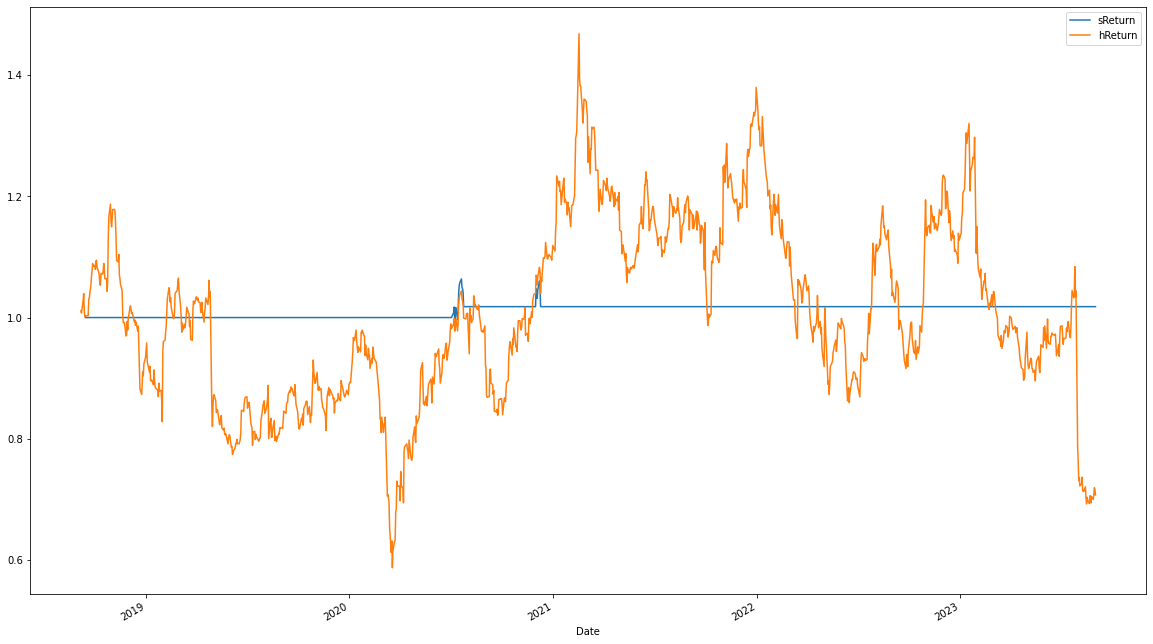

In [139]:
df[["sReturn", "hReturn"]].plot(figsize=(20,12))
# df["sReturn"].plot(figsize=(20,12))

In [28]:
# df[815:835]
df["1965-07-20":"1965-10-05"]

NameError: name 'df' is not defined

In [12]:
df["test"].value_counts()

1.00    25
2.00    25
3.00    25
Name: test, dtype: int64

In [13]:
np.exp(df["Day profit"].sum())
df[["Day profit", "Hold"]].sum().apply(np.exp) * 100

Day profit      190.68
Hold         27,143.11
dtype: float64

In [14]:
df["sReturn"].nsmallest(10)

Date
1965-04-15   1.01
1965-04-20   1.02
1965-04-21   1.02
1965-04-22   1.02
1965-04-23   1.02
1965-04-26   1.02
1965-04-27   1.02
1965-04-28   1.02
1965-04-29   1.02
1965-04-30   1.02
Name: sReturn, dtype: float64

In [31]:
mult_opt["ABEO"]
# tickers = ["ABEO", "ABIO", "ABVC", "ACHV", "ACER", "ACST", "AAIC", "ACRX", "ACOR", "ACET"]

,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
0,50,100,1,1.06,8,0.00
1,50,100,2,1.37,8,0.00
2,50,100,3,1.19,8,0.00
3,50,100,4,1.99,8,0.00
4,50,100,5,2.35,8,0.00
...,...,...,...,...,...,...
4045,78,245,5,1.29,4,0.00
4046,78,245,6,1.29,4,0.00
4047,78,245,7,0.98,4,0.00
4048,78,245,8,0.98,4,0.00


In [95]:
for ticker in mult_opt.columns.get_level_values(0).unique():
    print(ticker)
    display(mult_opt[ticker].sort_values("strategy return", ascending=False).head(5))

ABEO


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
808,54,245,8,3.75,10,0.00
529,52,240,8,3.75,10,0.00
1060,56,235,8,3.75,10,0.00
1078,56,245,8,3.75,10,0.00
511,52,230,8,3.75,10,0.00


ABVC


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
4049,78,245,9,2.81,3,0.00
1064,56,240,3,2.81,3,0.00
1048,56,230,5,2.81,3,0.00
1049,56,230,6,2.81,3,0.00
1050,56,230,7,2.81,3,0.00


ACHV


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
161,50,185,9,1.61,6,0.00
89,50,145,9,1.61,6,0.00
845,56,115,9,1.61,6,0.00
404,52,170,9,1.61,6,0.00
143,50,175,9,1.61,6,0.00


ACER


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
427,52,185,5,11.13,2,0.00
224,50,220,9,11.13,2,0.00
238,50,230,5,11.13,2,0.00
233,50,225,9,11.13,2,0.00
232,50,225,8,11.13,2,0.00


ACST


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
748,54,215,2,2.44,2,0.00
824,56,105,6,2.44,1,0.00
813,56,100,4,2.44,1,0.00
814,56,100,5,2.44,1,0.00
815,56,100,6,2.44,1,0.00


AAIC


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
3994,78,215,8,1.25,3,0.01
3391,74,180,8,1.25,3,0.01
3760,76,235,8,1.25,3,0.01
3445,74,210,8,1.25,3,0.01
3436,74,205,8,1.25,3,0.01


ABNB


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
811,56,100,2,1.04,1,0.92
424,52,185,2,1.04,1,0.92
416,52,180,3,1.04,1,0.92
1729,62,160,2,1.04,1,0.92
1721,62,155,3,1.04,1,0.92


TSLA


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
620,54,140,9,3.25,5,153.84
1421,60,135,9,3.25,5,153.84
3041,72,135,9,3.25,5,153.84
881,56,135,9,3.25,5,153.84
2510,68,140,9,3.25,5,153.84


AAPL


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
206,50,210,9,49.19,37,"1,476.14"
269,50,245,9,49.19,37,"1,476.14"
152,50,180,9,49.19,37,"1,476.14"
242,50,230,9,49.19,37,"1,476.14"
251,50,235,9,49.19,37,"1,476.14"


In [72]:
mult_opt["ABIO"]["strategy return"].sort_values(ascending=False)

TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

In [86]:
mult_opt.drop(columns="ABIO", level=0, axis=1, inplace=True)

In [78]:
fucking_shit = mult_opt.copy()

In [119]:
mask = mult_opt["ACHV"]["trail stop"] != 9
mult_opt["ACHV"][mask].sort_values("strategy return", ascending=False).head(20)

,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
880,56,135,8,1.50,6,0.00
871,56,130,8,1.50,6,0.00
61,50,130,8,1.50,6,0.00
376,52,155,8,1.50,6,0.00
322,52,125,8,1.50,6,0.00
88,50,145,8,1.50,6,0.00
853,56,120,8,1.50,6,0.00
178,50,195,8,1.50,6,0.00
349,52,140,8,1.50,6,0.00
52,50,125,8,1.50,6,0.00


<Axes: >

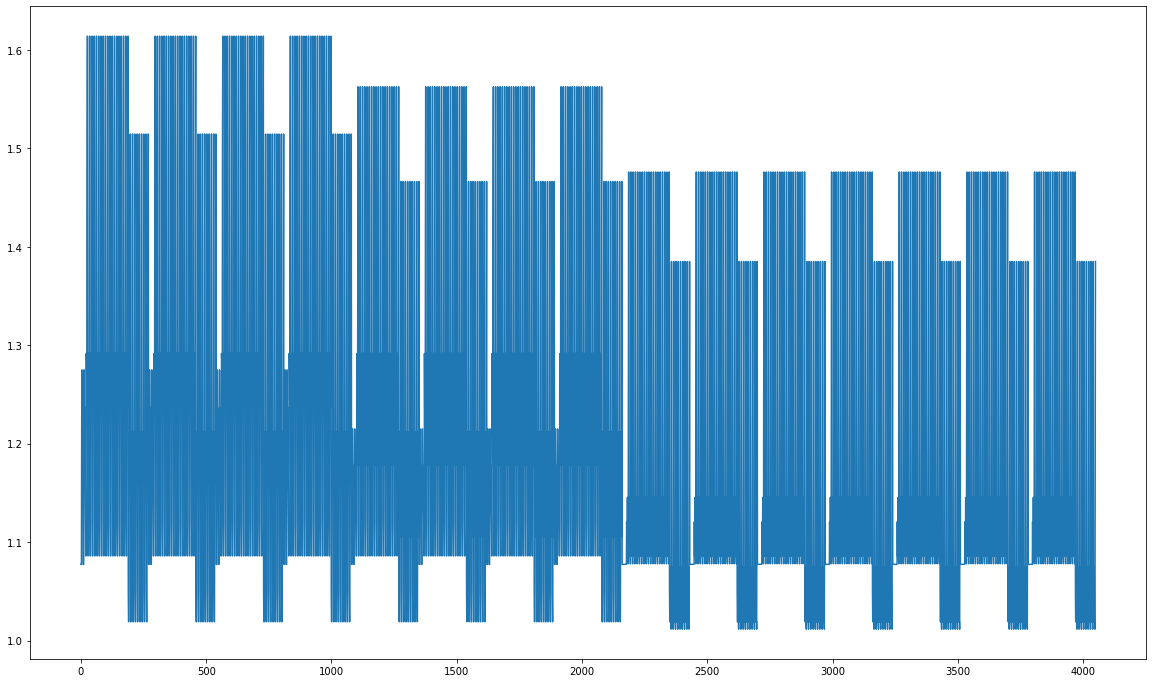

In [116]:
# mult_opt["ACHV"][["strategy return", "Hold return"]].plot(figsize=(20,12))
mult_opt["ACHV"]["strategy return"].plot(figsize=(20,12))